Travail developpe par le binome :
**Bruno OLIVEIRA, Samuel GHEZI**

Sur orientation de le Professeur **Martin GHIENNE**.

**Introduction**

L’exploitation d’un avion s’accompagne de conditions de vol très variables et difficiles à prédire, ce qui rend complexe l’estimation précise des chargements structuraux rencontrés en situation réelle. Bien que des informations telles que les déformations et les contraintes soient essentielles pour optimiser la maintenance et améliorer les modèles de dimensionnement, ces grandeurs ne sont généralement pas mesurées directement sur les aéronefs commerciaux. L’installation de capteurs dédiés entraînerait en effet une augmentation significative des coûts, de la masse, de la complexité d’intégration et des exigences de certification.

Le Mini-Challenge propose ainsi de développer un capteur virtuel basé sur des méthodes d’apprentissage automatique, capable d’estimer l’état de contrainte structurelle en différents points de l’avion à partir des seuls paramètres déjà enregistrés par l’instrumentation de bord. L’objectif est de prédire des grandeurs non mesurées physiquement, mais inférées à partir de variables de vol telles que l’attitude, les vitesses, les accélérations, les ordres de commande et les conditions de vent.

Pour cela, un ensemble de données réelles provenant de 44 vols d’essai est mis à disposition. Ce jeu de données comprend :

39 paramètres issus de l’instrumentation de bord, représentant l’état de vol, les efforts aérodynamiques et les actions de contrôle ;

15 jauges d’extensométrie (en micro-déformations, με) positionnées en différents points structuraux de l’appareil, permettant de mesurer directement les contraintes locales.

En résumé, ce projet vise à démontrer la capacité d’un modèle d’apprentissage supervisé à reproduire les contraintes structurelles réelles à partir de données opérationnelles courantes, ouvrant la voie à des stratégies de maintenance plus prédictives, moins coûteuses et mieux informées, dans la continuité des travaux précédents sur les capteurs virtuels pour le suivi de santé structurale.

Pour cette projet, on va se baser dans la teorie de Machine Learning, en se basent dans l'image ci dessous :

In [ ]:
# from IPython.display import Image
# (Image(filename="Workflow_DL.png"))

**Management des données**

Le liste de variable avec les description et sont format qui existe dans les données collectées pendant les vols sont en dessous :

In [ ]:
# (Image(filename="table.png"))


In [1]:
# Importing Lybraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Management des données** - Acquisition des données

In [ ]:
# Creating the dataframes data[Tol_1], ..., data[Tol_48]
# data = {}
# for file in glob.glob('./Data_AirLoadBench/TOL_*.csv'):
#     base = os.path.basename(file)
#     name = base.replace('.csv', '')
#     data[name]  = pd.read_csv(file)

In [ ]:
# Displaying the colums existing in each dataframe
data['TOL_1'].columns

Displayng the dataframes

In [ ]:
data['TOL_1']

In [ ]:
data['TOL_1'].columns

**Management des données** - Exploration des Données

In [ ]:
# # ============================================================
# # 1) Sélection du DataFrame principal
# # ============================================================
# df = data['TOL_1']   # Votre DataFrame d'origine


# # ============================================================
# # 2) Listes des colonnes (Y = variables de vol, X = strains)
# # ============================================================
# y_cols = [
#     'Relative_Time', 'Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA',
#     'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT',
#     'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1',
#     'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos',
#     'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2',
#     'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos',
#     'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos',
#     'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos'
# ]

# x_cols = [
#     'Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6',
#     'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12',
#     'Strain13', 'Strain14', 'Strain15'
# ]


# # ============================================================
# # 3) Conversion des colonnes en valeurs numériques
# #    (évite des erreurs si certaines colonnes contiennent du texte)
# # ============================================================
# df_numeric = df.copy()

# for col in y_cols + x_cols:
#     if col in df_numeric.columns:  # sécurité si une colonne manque
#         df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')


# # ============================================================
# # 4) Génération des graphiques de dispersion (scatter)
# #    Pour chaque strain, une figure contenant plusieurs sous-graphiques
# #    Axe X = strain, Axe Y = variable de vol
# # ============================================================
# for strain in x_cols:

#     if strain not in df_numeric.columns:
#         print(f"La colonne {strain} n'est pas présente dans le DataFrame, ignorée.")
#         continue

#     # grille 7x6 de sous-graphiques (42 cases, nous avons 41 variables Y)
#     fig, axes = plt.subplots(
#         nrows=7, 
#         ncols=6, 
#         figsize=(18, 20),
#         sharex=False, 
#         sharey=False
#     )
#     axes = axes.ravel()  # transforme la grille en liste linéaire

#     # Pour chaque variable Y, créer un scatter plot
#     for i, y in enumerate(y_cols):

#         if y not in df_numeric.columns:
#             print(f"La colonne {y} n'est pas présente dans le DataFrame, ignorée.")
#             continue

#         ax = axes[i]

#         ax.scatter(
#             df_numeric[strain],
#             df_numeric[y],
#             s=5,
#             alpha=0.5
#         )
#         ax.set_xlabel(strain, fontsize=8)
#         ax.set_ylabel(y, fontsize=8)
#         ax.tick_params(labelsize=8)

#     # Suppression des sous-graphiques inutilisés
#     for j in range(len(y_cols), len(axes)):
#         fig.delaxes(axes[j])

#     # Titre global de la figure
#     fig.suptitle(
#         f'Relation entre {strain} et les variables de vol (Données : TOL_1)',
#         fontsize=16
#     )

#     plt.tight_layout()
#     plt.savefig(f"scatter_{strain}.png", dpi=300)
#     plt.show()


# # ============================================================
# # 5) Heatmap des corrélations (optionnel mais très utile)
# #    Visualisation de la corrélation entre toutes les Y et toutes les Strains
# # ============================================================
# cols_present = [c for c in (y_cols + x_cols) if c in df_numeric.columns]

# # matrice de corrélation
# corr = df_numeric[cols_present].corr()

# # sous-matrice : lignes = Y, colonnes = Strains
# corr_sub = corr.loc[
#     [c for c in y_cols if c in corr.index],
#     [c for c in x_cols if c in corr.columns]
# ]

# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     corr_sub,
#     annot=True,
#     fmt=".2f",
#     cmap='coolwarm',
#     center=0,
#     annot_kws={"size": 8} 

# )
# plt.xlabel('Strains')
# plt.ylabel('Variables de vol')
# plt.title('Corrélations entre les variables de vol et les strains (TOL_1)')
# plt.savefig("heatmap_correlations_TOL1.png", dpi=300)
# plt.tight_layout()
# plt.show()



Ploting grqphs for correlation

In [ ]:
base_path = "./"

for i in range(1, 16):
    filename = f"{base_path}scatter_Strain{i}.png"
    
    img = mpimg.imread(filename)
    plt.figure(figsize=(20, 12))   # <<< ALTERADO PARA FICAR BEM GRANDE
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"scatter_Strain{i}.png", fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
img = mpimg.imread("heatmap_correlations_TOL1.png")

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Heatmap des corrélations (TOL_1)")
plt.show()

**Management des données** - Préparation des Données

In [ ]:
dfs = []  # lista para guardar todos os dataframes

for name, df in data.items():
    df_temp = df.copy()
    df_temp["Tol_ID"] = name     # adiciona coluna identificando o TOL
    dfs.append(df_temp)

# junta tudo em um dataframe só
df = pd.concat(dfs, ignore_index=True)

df.to_csv('df.csv', index=False)

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df = df.drop(columns='Relative_Time')

In [4]:
df.head(10)

Nz        Nx  Roll_Angle  Pitch_Angle  True_AOA  True_Sideslip  \
0  0.906212 -0.014912    0.147686    -0.311379  3.590025      -2.303673   
1  0.906212 -0.014912    0.147686    -0.311379  3.590025      -2.303673   
2  0.906212 -0.014912    0.147686    -0.311379  3.590025      -2.303673   
3  0.906212 -0.014912    0.147686    -0.311379  3.590025      -2.303673   
4  0.906212 -0.014912    0.147686    -0.311379  3.590025      -2.303673   
5  0.906212 -0.020238    0.147686    -0.311379  3.590025      -2.303673   
6  0.906212 -0.020238    0.147686    -0.311379  3.590025      -2.303673   
7  0.906212 -0.020238    0.147686    -0.311379  3.590025      -2.303673   
8  0.906212 -0.020238    0.147686    -0.311379  3.590025      -2.303673   
9  0.906212 -0.020238    0.147686    -0.311379  3.590025      -2.303673   

          FPA  True_Heading  CAS  TAS  ...   Strain7   Strain8   Strain9  \
0  146.080303    134.823861  0.0  0.0  ...  0.000000  0.000000  0.000000   
1  146.080303    134.823861  0.0  0.0  ... -0.601572 -0.884219 -0.463841   
2  146.080303    134.824664  0.0  0.0  ... -0.310433 -1.410038 -1.853289   
3  146.080303    134.825466  0.0  0.0  ...  0.424748 -1.414549 -1.854326   
4  146.080303    134.825466  0.0  0.0  ...  0.572497 -2.114138  2.512348   
5  146.080303    134.825466  0.0  0.0  ...  1.025526 -1.238943  3.135614   
6  146.080303    134.825466  0.0  0.0  ...  0.289817 -0.374608  1.565383   
7  146.080303    134.826069  0.0  0.0  ...  0.879296  0.489727 -0.923224   
8  146.080303    134.826269  0.0  0.0  ... -0.020616 -1.437107 -0.606083   
9  146.080303    134.825868  0.0  0.0  ...  0.434725  0.828243 -0.771030   

   Strain10  Strain11  Strain12  Strain13  Strain14  Strain15  Tol_ID  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   TOL_1  
1  0.161175 -0.000325 -0.143096  0.403351  0.006286  0.175358   TOL_1  
2  0.646155 -0.000651 -0.571435  0.818918  0.012573  0.350715   TOL_1  
3  0.174219 -0.000976 -1.013577  1.216162 -1.045466 -0.521183   TOL_1  
4  0.644700  0.579980 -0.572384  1.613406  0.691031  0.003260   TOL_1  
5  0.486903  0.579654 -0.572858  1.613664  0.691860  0.004075   TOL_1  
6  0.319440  0.579329 -0.577933  1.595600  0.004970  0.004890   TOL_1  
7  0.166476  0.572297 -0.576107 -0.181416 -1.214082 -0.517923   TOL_1  
8  0.013512  0.578679 -0.574281  0.820468  0.006627  0.006520   TOL_1  
9  0.319675  0.578353 -0.577056  0.613072  0.184843  0.181878   TOL_1  

[10 rows x 55 columns]

In [5]:
# Targets = deformações (saídas do modelo)
target_cols = [f"Strain{i}" for i in range(1, 16)]

# Features = todas as colunas menos Strains e Flight_ID
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1', 'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [6]:
# Remove linhas com NaN nas colunas importantes
df_clean = df.dropna(subset=feature_cols + target_cols)

X = df_clean[feature_cols].values      # inputs
y = df_clean[target_cols].values      # outputs (strains)
Tol_ids = df_clean["Tol_ID"].values  # TOL related

In [7]:

X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, Tol_ids,
    test_size=0.3,
    random_state=42,
    stratify=Tol_ids
)

X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.5,
    random_state=42,
    stratify=ids_temp
)

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

In [9]:
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StrainDataset(X_train_scaled, y_train_scaled)
val_ds   = StrainDataset(X_val_scaled,   y_val_scaled)
test_ds  = StrainDataset(X_test_scaled,  y_test_scaled)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

In [10]:
n_features = X_train_scaled.shape[1]
n_outputs  = y_train_scaled.shape[1]   # 15 strains

class StrainMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StrainMLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

train_loss = []
val_loss   = []

best_val_loss    = float('inf')  # Starts with infinity
patience         = 5             # Wich epochs wait without getting better 
patience_counter = 0

n_epochs = 30

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss   = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}")

    # Verification
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save the best model
        torch.save(model.state_dict(), "best_model_MLP.pth")

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping: validation loss did not improve.")
            break

100%|██████████| 19303/19303 [01:20<00:00, 238.69it/s]


Epoch 001 | Train loss: 0.129939 | Val loss: 0.092515


100%|██████████| 19303/19303 [01:15<00:00, 255.94it/s]


Epoch 002 | Train loss: 0.080637 | Val loss: 0.071673


100%|██████████| 19303/19303 [01:24<00:00, 229.40it/s]


Epoch 003 | Train loss: 0.067185 | Val loss: 0.062184


100%|██████████| 19303/19303 [01:37<00:00, 198.32it/s]


Epoch 004 | Train loss: 0.060038 | Val loss: 0.057984


100%|██████████| 19303/19303 [01:42<00:00, 189.01it/s]


Epoch 005 | Train loss: 0.055594 | Val loss: 0.055814


100%|██████████| 19303/19303 [01:44<00:00, 184.12it/s]


Epoch 006 | Train loss: 0.052612 | Val loss: 0.052760


100%|██████████| 19303/19303 [01:45<00:00, 183.03it/s]


Epoch 007 | Train loss: 0.050398 | Val loss: 0.050680


100%|██████████| 19303/19303 [01:45<00:00, 183.02it/s]


Epoch 008 | Train loss: 0.048648 | Val loss: 0.048617


100%|██████████| 19303/19303 [01:45<00:00, 183.82it/s]


Epoch 009 | Train loss: 0.047281 | Val loss: 0.046581


100%|██████████| 19303/19303 [01:47<00:00, 179.99it/s]


Epoch 010 | Train loss: 0.046135 | Val loss: 0.045269


100%|██████████| 19303/19303 [01:45<00:00, 182.81it/s]


Epoch 011 | Train loss: 0.045058 | Val loss: 0.045962


100%|██████████| 19303/19303 [01:45<00:00, 182.76it/s]


Epoch 012 | Train loss: 0.044317 | Val loss: 0.044389


100%|██████████| 19303/19303 [01:33<00:00, 206.82it/s]


Epoch 013 | Train loss: 0.043545 | Val loss: 0.043543


100%|██████████| 19303/19303 [01:22<00:00, 235.19it/s]


Epoch 014 | Train loss: 0.042896 | Val loss: 0.044016


100%|██████████| 19303/19303 [01:20<00:00, 239.15it/s]


Epoch 015 | Train loss: 0.042307 | Val loss: 0.041793


100%|██████████| 19303/19303 [01:20<00:00, 238.43it/s]


Epoch 016 | Train loss: 0.041795 | Val loss: 0.042073


100%|██████████| 19303/19303 [01:19<00:00, 244.17it/s]


Epoch 017 | Train loss: 0.041341 | Val loss: 0.042306


100%|██████████| 19303/19303 [01:20<00:00, 241.19it/s]


Epoch 018 | Train loss: 0.040908 | Val loss: 0.041082


100%|██████████| 19303/19303 [01:20<00:00, 241.01it/s]


Epoch 019 | Train loss: 0.040521 | Val loss: 0.041164


100%|██████████| 19303/19303 [01:19<00:00, 244.33it/s]


Epoch 020 | Train loss: 0.040164 | Val loss: 0.040546


100%|██████████| 19303/19303 [01:20<00:00, 240.02it/s]


Epoch 021 | Train loss: 0.039814 | Val loss: 0.039990


100%|██████████| 19303/19303 [01:19<00:00, 243.34it/s]


Epoch 022 | Train loss: 0.039539 | Val loss: 0.040046


100%|██████████| 19303/19303 [01:19<00:00, 243.03it/s]


Epoch 023 | Train loss: 0.039237 | Val loss: 0.038975


100%|██████████| 19303/19303 [01:19<00:00, 244.15it/s]


Epoch 024 | Train loss: 0.038989 | Val loss: 0.040417


100%|██████████| 19303/19303 [01:19<00:00, 243.53it/s]


Epoch 025 | Train loss: 0.038781 | Val loss: 0.039459


100%|██████████| 19303/19303 [01:20<00:00, 240.11it/s]


Epoch 026 | Train loss: 0.038544 | Val loss: 0.038520


100%|██████████| 19303/19303 [01:19<00:00, 242.94it/s]


Epoch 027 | Train loss: 0.038344 | Val loss: 0.038401


100%|██████████| 19303/19303 [01:19<00:00, 241.46it/s]


Epoch 028 | Train loss: 0.038096 | Val loss: 0.039040


100%|██████████| 19303/19303 [01:20<00:00, 240.94it/s]


Epoch 029 | Train loss: 0.037943 | Val loss: 0.037794


100%|██████████| 19303/19303 [01:19<00:00, 242.39it/s]


Epoch 030 | Train loss: 0.037767 | Val loss: 0.040613


In [15]:
train_loss

0.037767487154502864

In [16]:
train_losses = [
0.129939, 0.080637, 0.067185, 0.060038, 0.055594,
0.052612, 0.050398, 0.048648, 0.047281, 0.046135,
0.045058, 0.044317, 0.043545, 0.042896, 0.042307,
0.041795, 0.041341, 0.040908, 0.040521, 0.040164,
0.039814, 0.039539, 0.039237, 0.038989, 0.038781,
0.038544, 0.038344, 0.038096, 0.037943, 0.037767
]

val_losses = [
0.092515, 0.071673, 0.062184, 0.057984, 0.055814,
0.052760, 0.050680, 0.048617, 0.046581, 0.045269,
0.045962, 0.044389, 0.043543, 0.044016, 0.041793,
0.042073, 0.042306, 0.041082, 0.041164, 0.040546,
0.039990, 0.040046, 0.038975, 0.040417, 0.039459,
0.038520, 0.038401, 0.039040, 0.037794, 0.040613
]



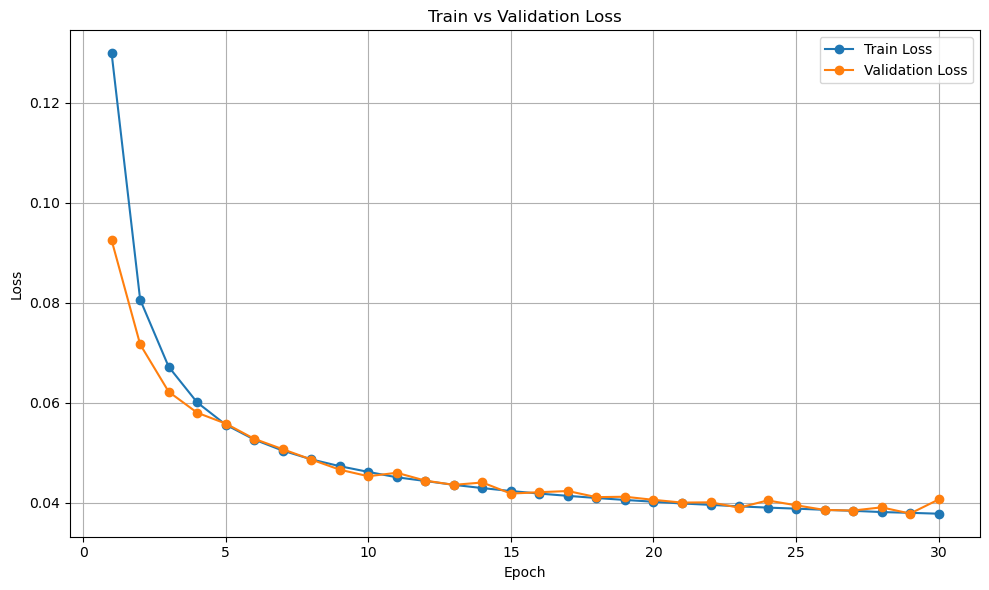

In [17]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

lire les images de le training up side

In [18]:
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# Global metrics
mae_global  = mean_absolute_error(y_test_real, y_pred_real)
rmse_global = mean_squared_error(y_test_real, y_pred_real, squared=False)
r2_global   = r2_score(y_test_real, y_pred_real)

print("Overall metrics in the test set:")
print(f"MAE  : {mae_global:.4f}")
print(f"RMSE : {rmse_global:.4f}")
print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 20.7183
RMSE : 32.0403
R²   : 0.9592


In [19]:
metrics_per_flight = {}
unique_flights = np.unique(ids_test)

for flight in unique_flights:
    mask = (ids_test == flight)
    y_true_f = y_test_real[mask]
    y_pred_f = y_pred_real[mask]

    mae  = mean_absolute_error(y_true_f, y_pred_f)
    rmse = mean_squared_error(y_true_f, y_pred_f, squared=False)
    r2   = r2_score(y_true_f, y_pred_f)

    metrics_per_flight[flight] = {"MAE": mae, "RMSE": rmse, "R2": r2}

for flight, m in metrics_per_flight.items():
    print(f"{flight}: MAE={m['MAE']:.4f}, RMSE={m['RMSE']:.4f}, R²={m['R2']:.4f}")

mae_mean  = np.mean([m["MAE"]  for m in metrics_per_flight.values()])
rmse_mean = np.mean([m["RMSE"] for m in metrics_per_flight.values()])
r2_mean   = np.mean([m["R2"]   for m in metrics_per_flight.values()])

print("\nAverage metrics across all TOLs (test):")
print(f"MAE médio  : {mae_mean:.4f}")
print(f"RMSE médio : {rmse_mean:.4f}")
print(f"R² médio   : {r2_mean:.4f}")

TOL_1: MAE=17.9847, RMSE=26.4118, R²=0.9642
TOL_10: MAE=18.3684, RMSE=27.4870, R²=0.9321
TOL_11: MAE=19.9590, RMSE=31.0393, R²=0.9263
TOL_12: MAE=24.9233, RMSE=38.0370, R²=0.9192
TOL_13: MAE=19.5975, RMSE=27.0173, R²=0.9506
TOL_14: MAE=24.0018, RMSE=36.7833, R²=0.9409
TOL_15: MAE=25.6259, RMSE=38.8551, R²=0.9411
TOL_17: MAE=19.7785, RMSE=27.6135, R²=0.9552
TOL_18: MAE=26.9106, RMSE=42.4373, R²=0.9142
TOL_19: MAE=20.2270, RMSE=31.5020, R²=0.9350
TOL_2: MAE=17.9963, RMSE=26.0714, R²=0.9397
TOL_20: MAE=24.9867, RMSE=37.2057, R²=0.9251
TOL_21: MAE=17.0089, RMSE=25.6968, R²=0.9645
TOL_22: MAE=14.0555, RMSE=19.4997, R²=0.9010
TOL_23: MAE=18.4640, RMSE=29.8829, R²=0.9270
TOL_24: MAE=17.6422, RMSE=25.2002, R²=0.9409
TOL_25: MAE=18.4485, RMSE=27.3379, R²=0.9614
TOL_26: MAE=24.1599, RMSE=38.3799, R²=0.9493
TOL_27: MAE=20.5943, RMSE=30.2688, R²=0.8979
TOL_28: MAE=22.8411, RMSE=34.9294, R²=0.9196
TOL_29: MAE=20.4589, RMSE=31.8744, R²=0.9398
TOL_3: MAE=16.4259, RMSE=22.8948, R²=0.9594
TOL_30: MAE=1

In [ ]:
df_flights = pd.DataFrame.from_dict(metrics_per_flight, orient='index')

df_global = pd.DataFrame({
    "MAE":  [mae_global],
    "RMSE": [rmse_global],
    "R2":   [r2_global]
}, index=["GLOBAL"])


df_results = pd.concat([df_flights, df_global])



In [ ]:
df_results.to_csv('df_results_all_2d.csv')

In [ ]:
df_results = pd.read_csv('df_results_all_2d.csv')
df_results


Unnamed: 0        MAE       RMSE        R2
0       TOL_1  17.552930  25.805530  0.965695
1      TOL_10  18.089918  26.275248  0.939663
2      TOL_11  18.872680  29.858081  0.931578
3      TOL_12  23.335688  35.186905  0.933199
4      TOL_13  19.306073  26.484897  0.952701
5      TOL_14  23.404106  35.351755  0.944909
6      TOL_15  25.653372  37.822956  0.944918
7      TOL_17  19.852090  28.018926  0.955206
8      TOL_18  25.425999  40.422416  0.922942
9      TOL_19  20.127155  32.340869  0.932146
10      TOL_2  16.064838  24.193439  0.946496
11     TOL_20  24.163556  35.831895  0.929522
12     TOL_21  15.966403  23.963220  0.968268
13     TOL_22  14.170142  19.530792  0.905668
14     TOL_23  17.166394  27.232628  0.935050
15     TOL_24  16.698332  24.079685  0.943712
16     TOL_25  17.570219  25.512656  0.963809
17     TOL_26  22.466070  36.764028  0.954572
18     TOL_27  19.887767  29.018079  0.907208
19     TOL_28  22.631228  35.016059  0.920998
20     TOL_29  21.156724  31.313867  0.940287
21      TOL_3  14.430025  20.513847  0.967834
22     TOL_30  16.033827  25.539388  0.924245
23     TOL_31  21.096657  34.316257  0.947185
24     TOL_33  18.169947  25.762809  0.946272
25     TOL_34  17.759067  25.739921  0.970247
26     TOL_35  29.093708  43.525615  0.855692
27     TOL_36  20.724829  30.708572  0.956041
28     TOL_37  19.053424  27.857088  0.940077
29     TOL_38  20.542838  30.916273  0.952715
30     TOL_39  19.836036  29.494543  0.966823
31      TOL_4  26.069239  40.927511  0.925888
32     TOL_40  23.701845  37.806692  0.966112
33     TOL_41  13.567616  18.418510  0.974743
34     TOL_42  16.845317  24.428209  0.966930
35     TOL_43  20.032977  30.383364  0.959789
36     TOL_44  20.044751  30.594495  0.921006
37     TOL_46  21.935012  33.185915  0.899653
38     TOL_48  18.230222  25.750599  0.974515
39      TOL_5  25.158815  40.414484  0.898419
40      TOL_6  14.842519  21.869744  0.920180
41      TOL_7  26.846871  38.670518  0.941931
42      TOL_8  26.588439  38.925633  0.942016
43      TOL_9  20.870595  32.599776  0.967336
44     GLOBAL  20.198780  31.112246  0.961697

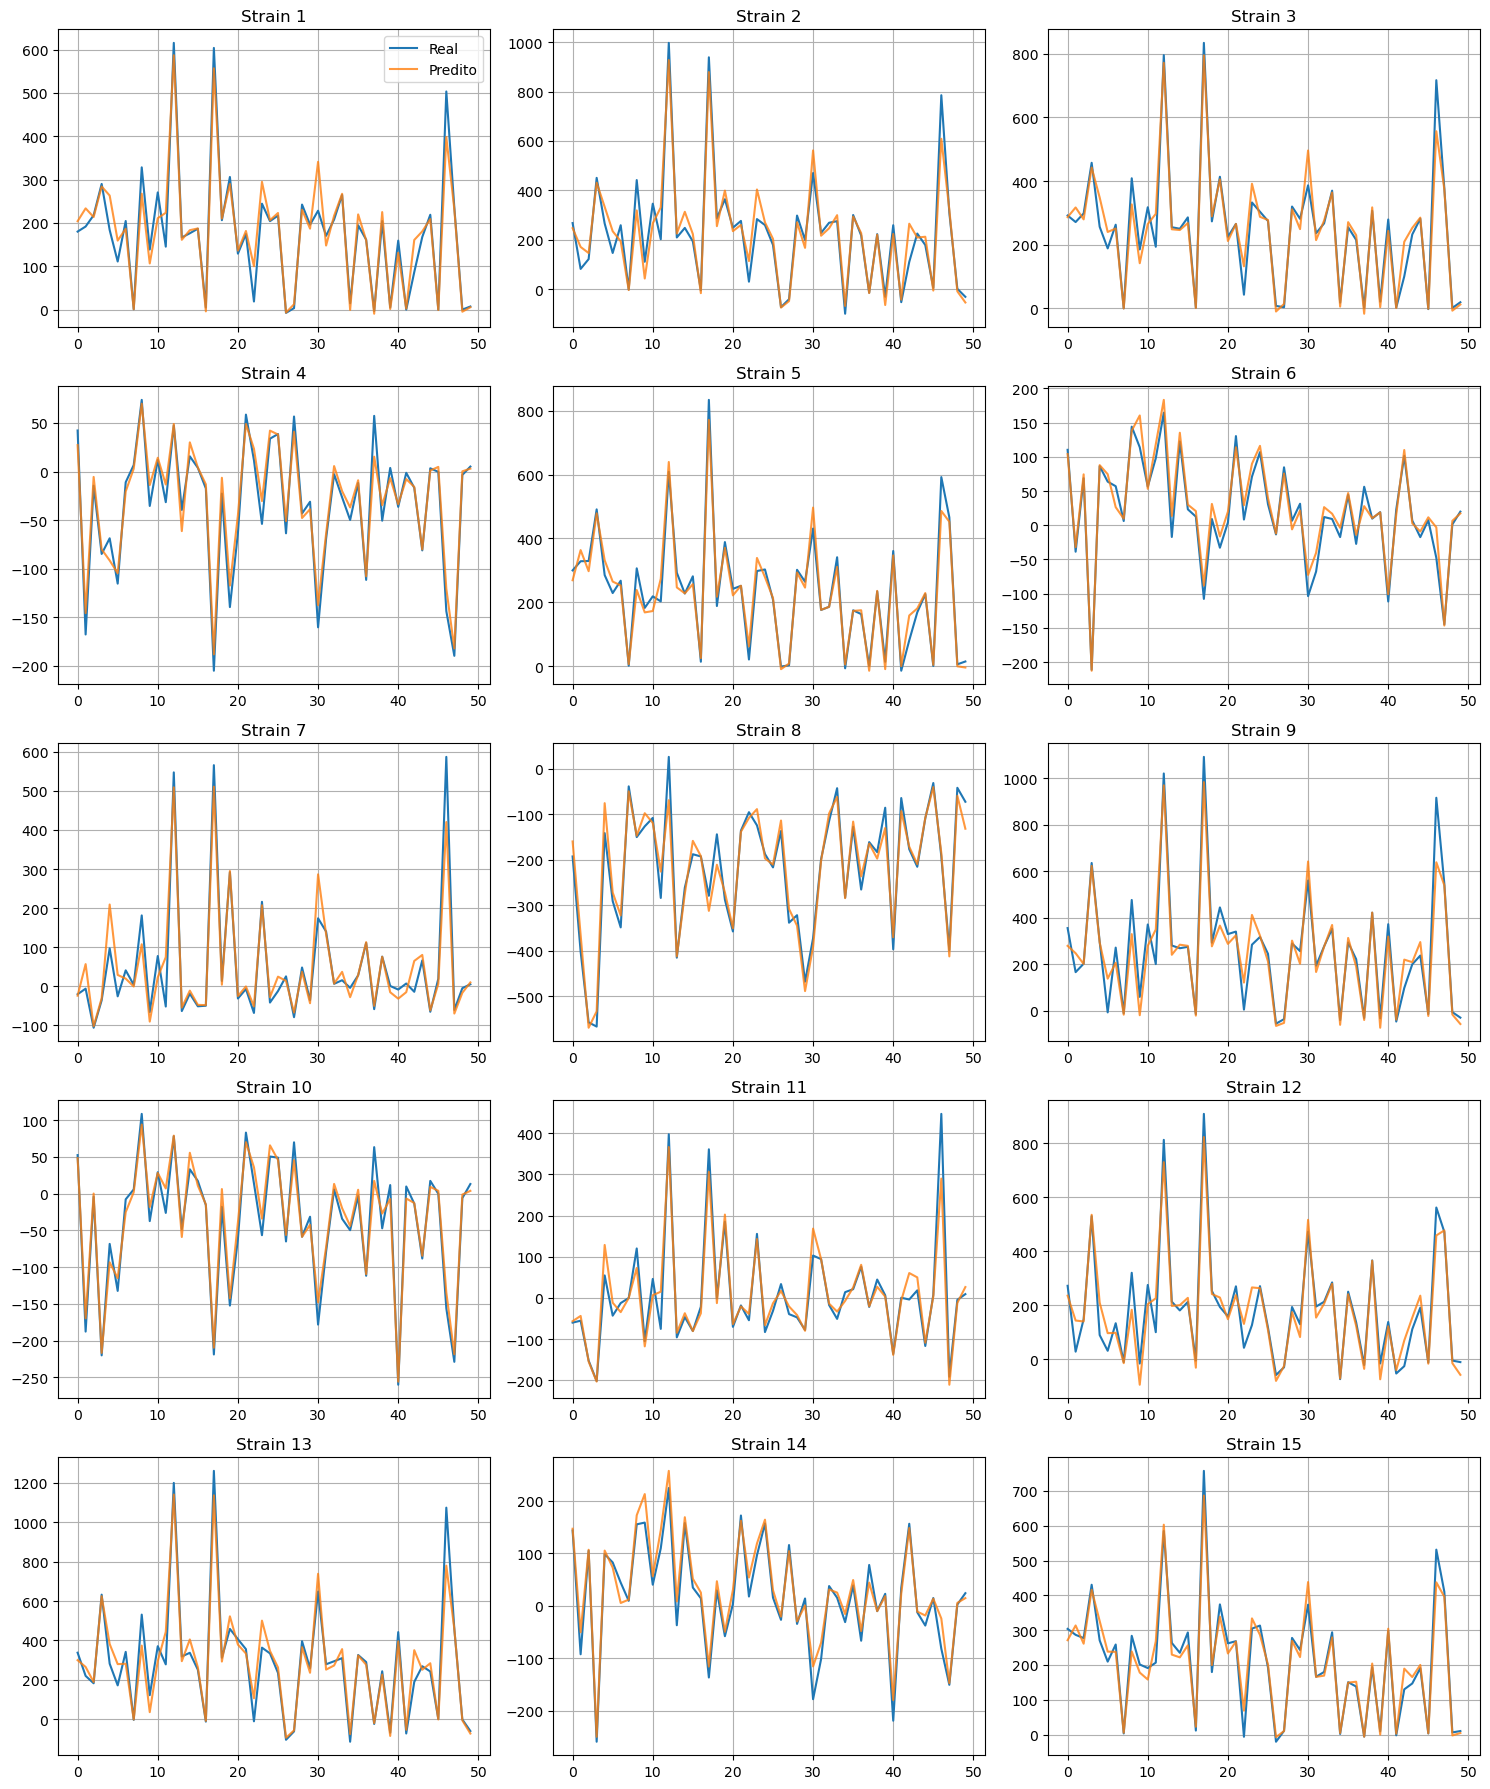

In [ ]:
N = 50  # Number of point in the x axis

plt.figure(figsize=(15, 18))

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.plot(y_test_real[:N, i], label="Real")
    plt.plot(y_pred_real[:N, i], label="Predito", alpha=0.8)
    plt.title(f"Strain {i+1}")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

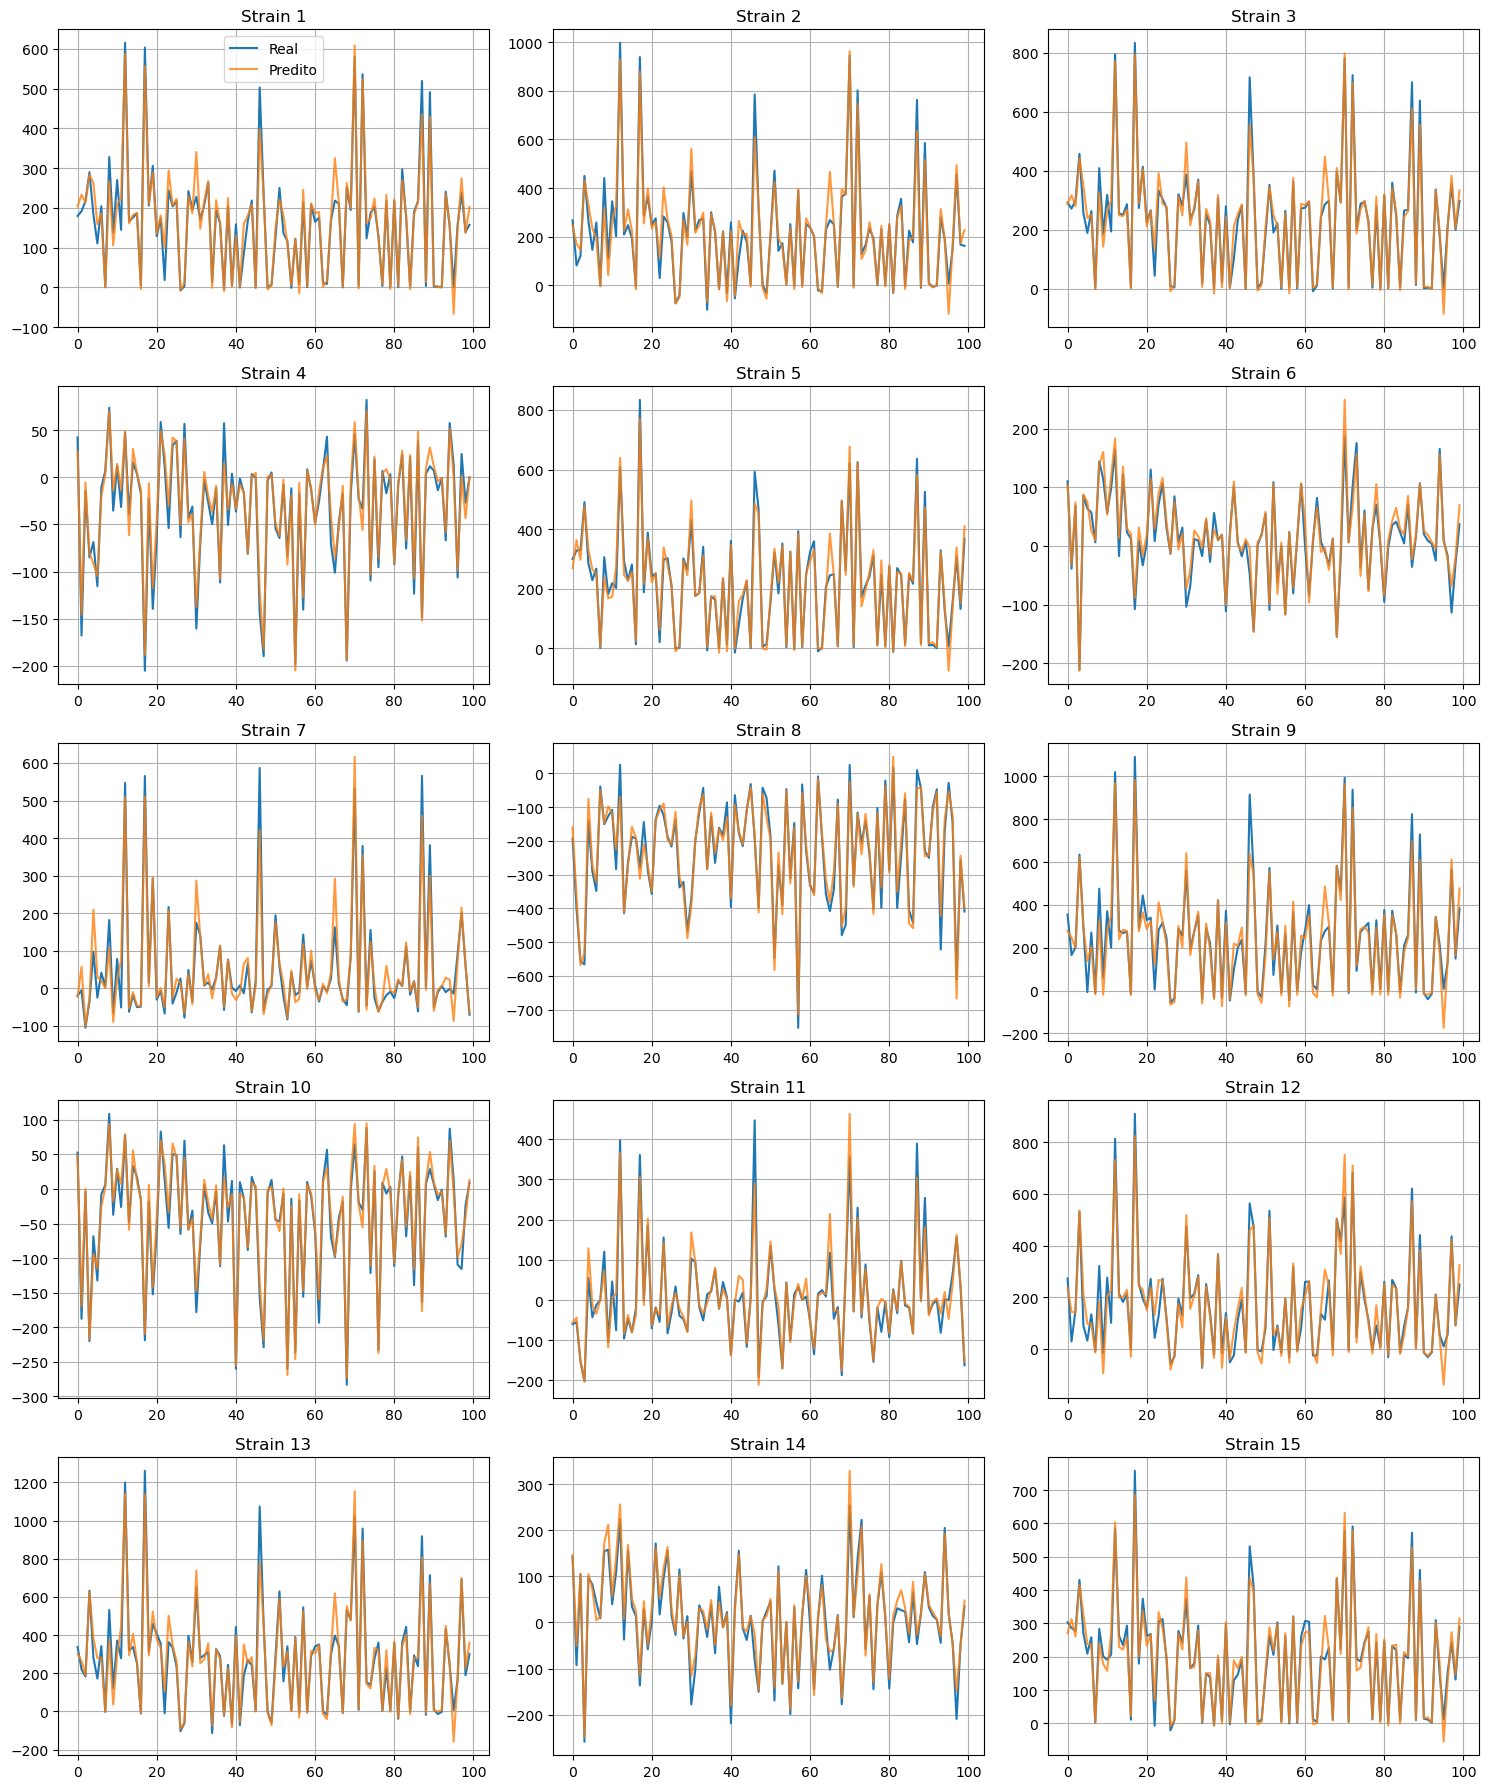

In [ ]:
N = 100  

plt.figure(figsize=(15, 18))

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.plot(y_test_real[:N, i], label="Real")
    plt.plot(y_pred_real[:N, i], label="Predito", alpha=0.8)
    plt.title(f"Strain {i+1}")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

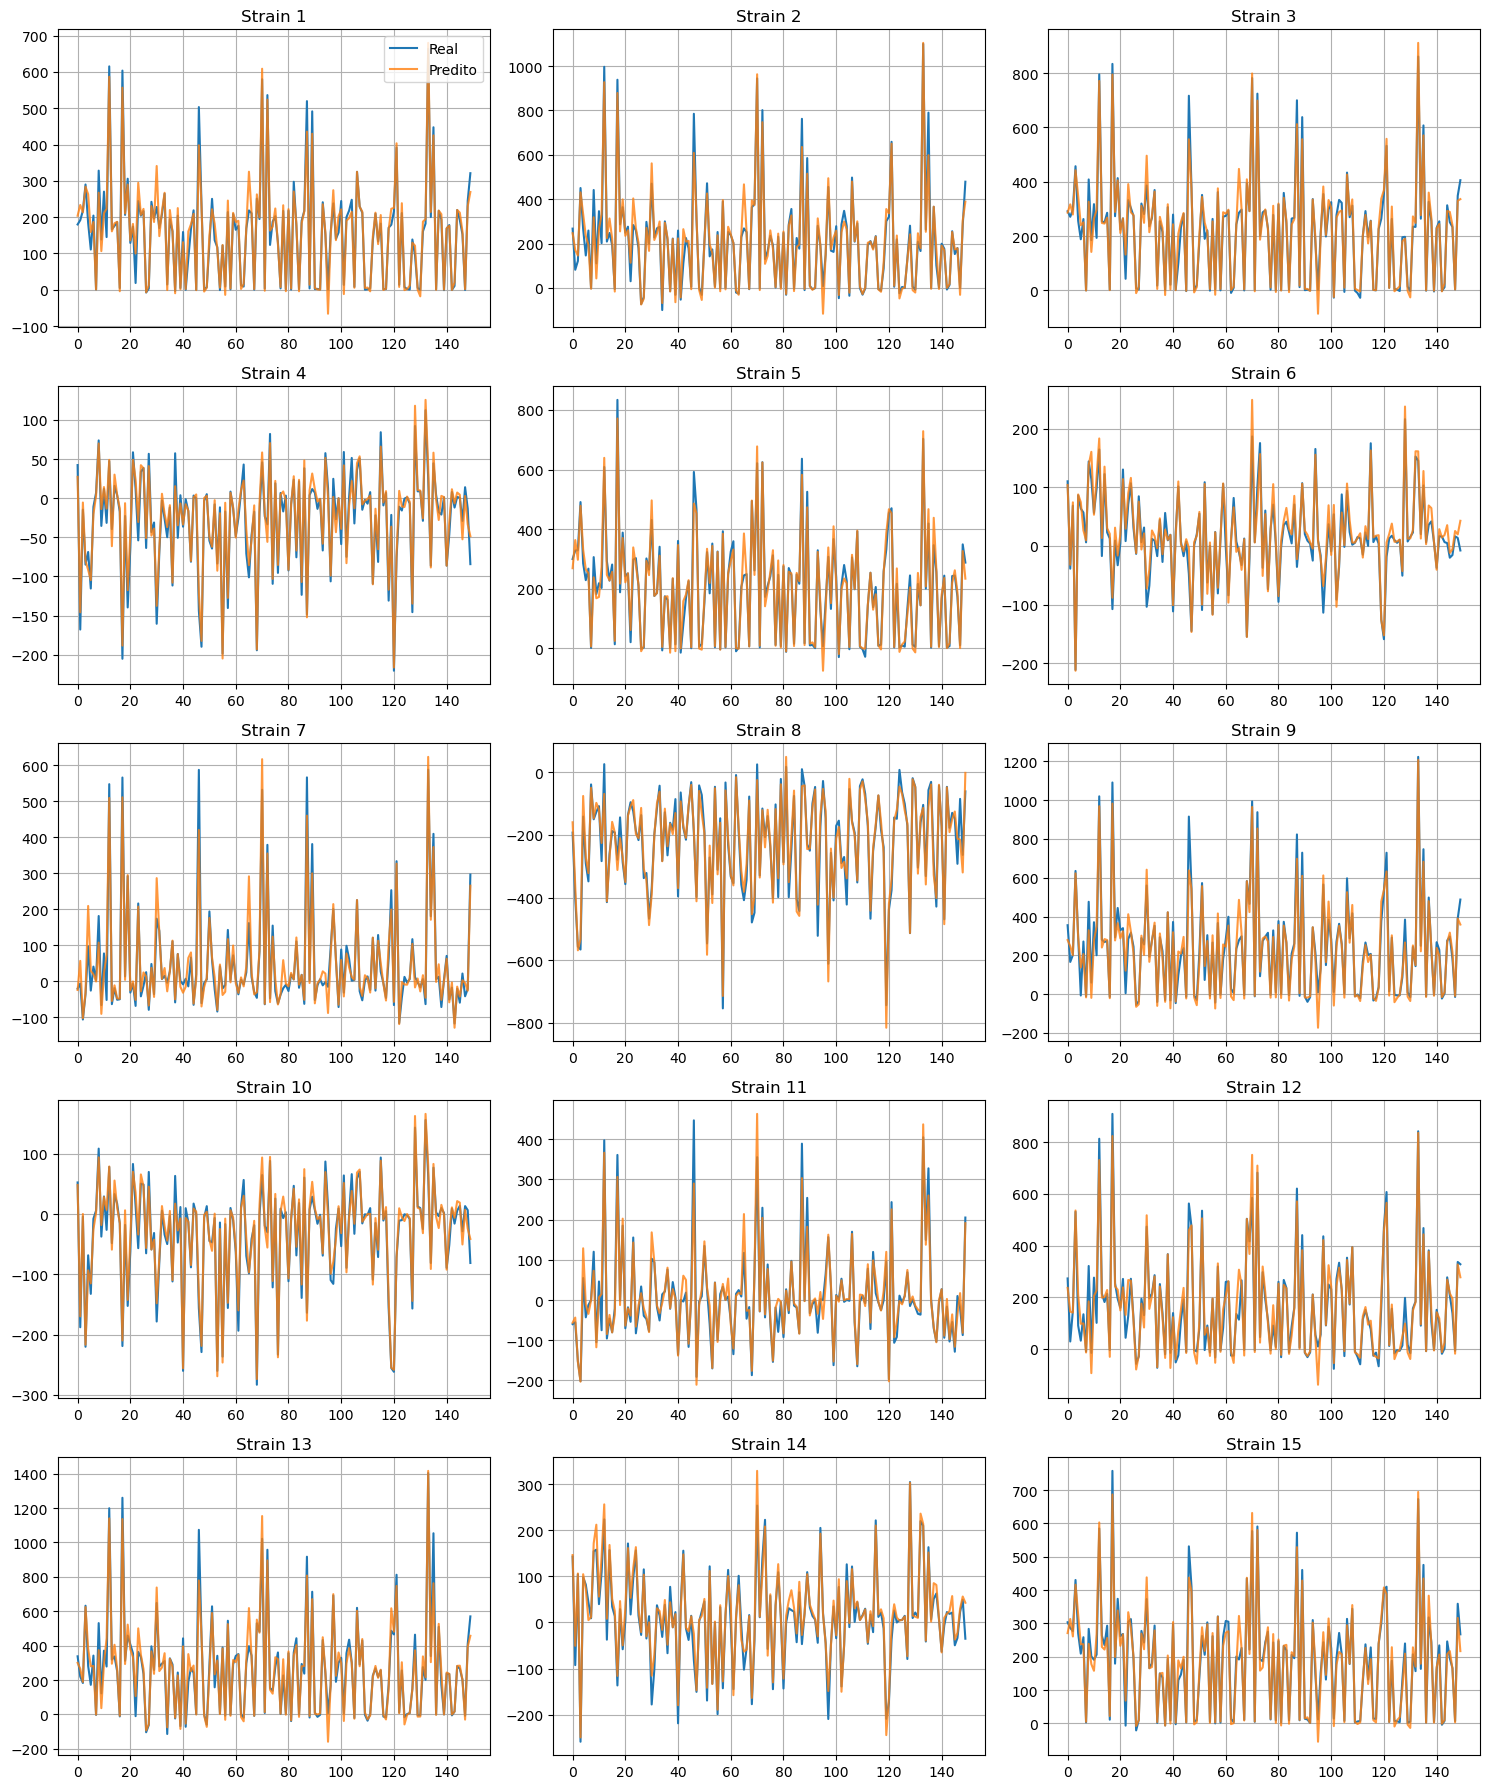

In [ ]:
N = 150  

plt.figure(figsize=(15, 18))

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.plot(y_test_real[:N, i], label="Real")
    plt.plot(y_pred_real[:N, i], label="Predito", alpha=0.8)
    plt.title(f"Strain {i+1}")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

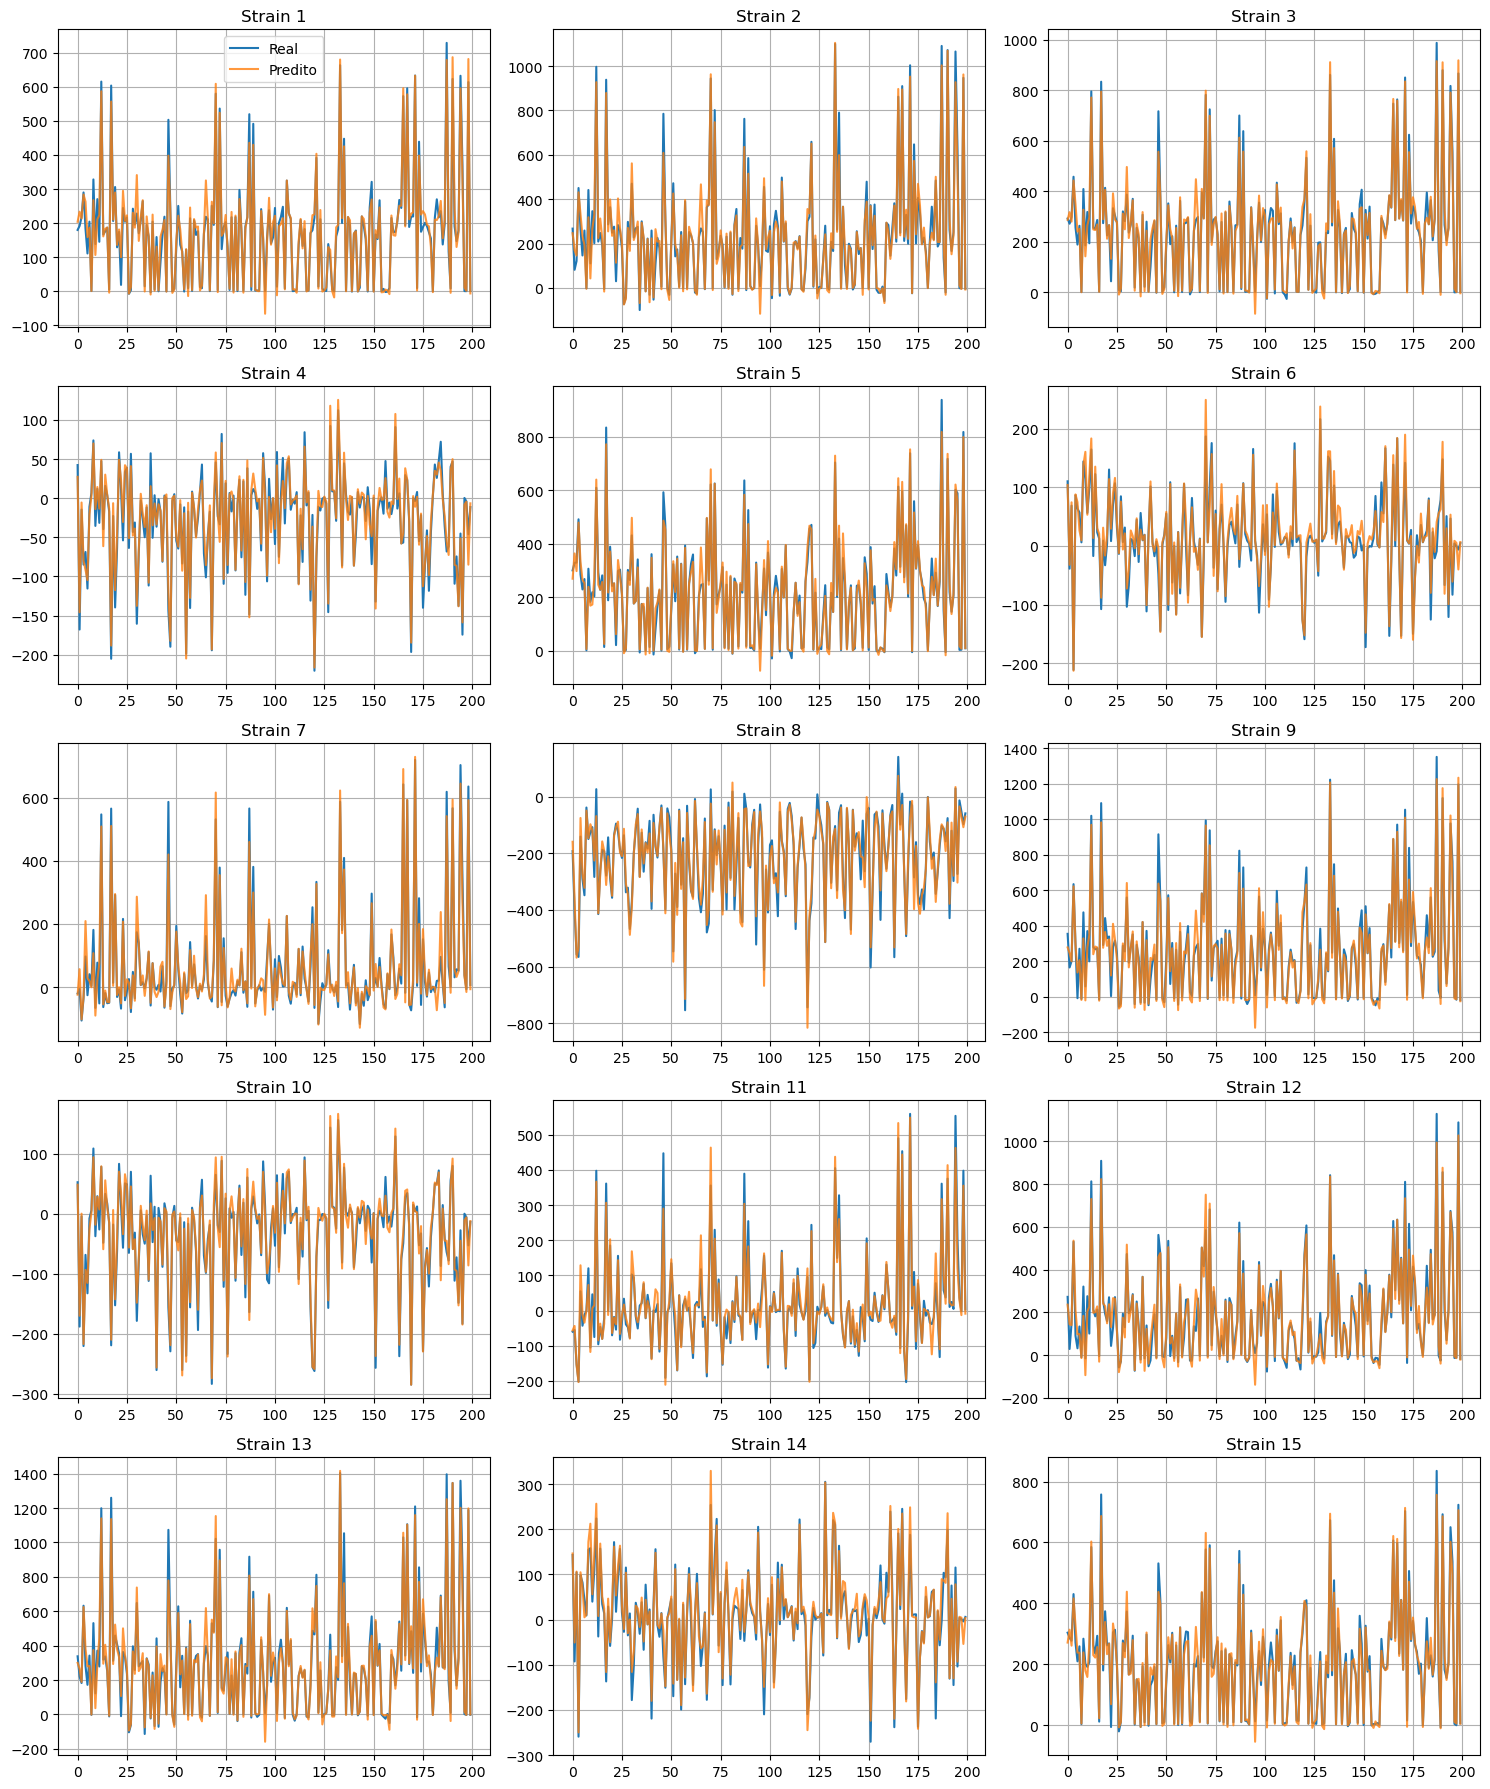

In [ ]:
N = 200  

plt.figure(figsize=(15, 18))

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.plot(y_test_real[:N, i], label="Real")
    plt.plot(y_pred_real[:N, i], label="Predito", alpha=0.8)
    plt.title(f"Strain {i+1}")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from copy import deepcopy

### Redefinie feature_names and target_names if your model needs it
feature_names = ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA',
'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT',
'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1',
'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos',
'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2',
'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos',
'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos',
'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos'
]
target_names = ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6',
'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12',
'Strain13', 'Strain14', 'Strain15']

### Copy your model (after training)
trained_model = deepcopy(model)

### Complete with a deepcopy of your scalers if you used one
my_scaler_X = deepcopy(scaler_X)
my_scaler_y = deepcopy(scaler_y)

In [35]:
from pathlib import Path
# from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score

dirtest = Path("Data_AirLoadBench_test/")
test_flights = ["TOL_16.csv","TOL_45.csv","TOL_32.csv","TOL_47.csv"]
df_test = {}

for flight in test_flights:
    df_test[flight] = pd.read_csv(dirtest / flight,usecols=feature_names+target_names)

### Compute performance on each flight of the test_set
rmse = []
r2 = []
for flight_nb in test_flights:
    y_test_true = df_test[flight_nb][target_names]
    X_test = my_scaler_X.transform(df_test[flight_nb][feature_names])
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_pred_norm = trained_model(X_test)
    y_pred = my_scaler_y.inverse_transform(y_pred_norm.detach().numpy())

    rmse.append(np.sqrt(mean_squared_error(y_test_true,y_pred)))
    r2.append(r2_score(y_test_true,y_pred))
    print(f"Root Mean Square Error (RMSE) on flight {flight_nb} = {rmse[-1]}")
    print(f"R-square (R2) on flight {flight_nb} = {r2[-1]}")

### Print overal preformance on test set
print('─' * 50 +
f"\nOverall RMSE on test_set = {np.mean(rmse)} \n" +
f"Overall R2 on test_set = {np.mean(r2)} \n" +
'─' * 50)

### Plot gauge prediction
fig, axs = plt.subplots(3,5, figsize=(25, 10))
fig.suptitle(f"Strain gauge prediction for flight {flight_nb}", fontsize=14)
fig.subplots_adjust(hspace = .5, wspace=.001)
for i in range(15):
    axs[i//5,i-(i//5)*5].plot(y_test_true[f"Strain{i+1}"], label=f"True Strain{i+1}")
    axs[i//5,i-(i//5)*5].plot(y_pred[:,i], label=f"True Strain{i+1}")
    axs[i//5,i-(i//5)*5].legend(loc = 'best')